In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [1]:
%cd '/content/drive/MyDrive/Cov19/input'

/content/drive/MyDrive/Cov19/input


In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, add, multiply
from keras.layers import Multiply, UpSampling2D, core
from keras.layers.merge import concatenate
from keras.layers.core import Lambda
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology as morph
from skimage import measure

# 1. Loading data


In [43]:
infile = open('Processed_Data.cp','rb')
data_dict = pickle.load(infile)
all_cts = data_dict['cts']
all_lungs = data_dict['lungs']
all_inf = data_dict['infects']
infile.close()

In [44]:
print(all_cts.shape)
print(all_lungs.shape)
print(all_inf.shape)

(1564, 128, 128, 1)
(1564, 128, 128, 1)
(1564, 128, 128, 1)


In [45]:
from sklearn.utils import shuffle
all_cts, all_lungs, all_inf = shuffle(all_cts, all_lungs, all_inf)

In [46]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_lungs = (all_lungs - all_lungs.min())/(all_lungs.max()-all_lungs.min())
all_inf = (all_inf - all_inf.min())/(all_inf.max()-all_inf.min())

print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_lungs.min(), all_lungs.max()))
print("{} {}".format(all_inf.min(), all_inf.max()))

0.0 1.0
0.0 1.0
0.0 1.0


# 2. Splitting data into training and validation sets

In [47]:
train_size = int(0.65*all_cts.shape[0])
X_train, yl_train, yi_train = (all_cts[:train_size]/255, all_lungs[:train_size], all_inf[:train_size])
X_valid, yl_valid, yi_valid = (all_cts[train_size:int(0.8*all_cts.shape[0])]/255, 
                               all_lungs[train_size:int(0.8*all_cts.shape[0])], 
                               all_inf[train_size:int(0.8*all_cts.shape[0])])
test_size = int(0.8*all_cts.shape[0])
X_test, yl_test, yi_test = (all_cts[test_size:]/255, all_lungs[test_size:], all_inf[test_size:])
print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_valid.shape, yl_valid.shape, yi_valid.shape)
print(X_test.shape, yl_test.shape, yi_test.shape)

(1016, 128, 128, 1) (1016, 128, 128, 1) (1016, 128, 128, 1)
(235, 128, 128, 1) (235, 128, 128, 1) (235, 128, 128, 1)
(313, 128, 128, 1) (313, 128, 128, 1) (313, 128, 128, 1)


# 3. Define evaluation metrics
We will use dice coefficient as a metric for infection segmentation. Dice coefficient is (2TP/2TP+FN+FP) where TP, FN and FP correspond to true positive, false negative and false positive. Code taken from
https://medium.com/@karan_jakhar/100-days-of-code-day-7-84e4918cb72c

In [48]:
def dice(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_loss(y_true, y_pred):
  loss = 1 - dice(y_true, y_pred)
  return loss

def bce_dice_loss(y_true, y_pred):
  loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
  return loss

class CosineAnnealingLearningRateSchedule(callbacks.Callback):
  def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
    self.epochs = n_epochs
    self.cycles = n_cycles
    self.lr_max = lrate_max
    self.lrates = list()

  def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = np.floor(n_epochs/n_cycles)
    cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_max/2 * (np.cos(cos_inner) + 1)

  def on_epoch_begin(self, epoch, logs=None):
    lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
    K.set_value(self.model.optimizer.lr, lr)
    self.lrates.append(lr)

# 4. CNN


In [49]:
def block1 (input_shape, filtersize, poolsz=(2,2)) :
    x = Conv2D(filtersize, (3,3), activation='relu', padding='same', kernel_initializer="he_normal") (input_shape)
    x = Conv2D(filtersize, (3,3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization()(x)
    x = MaxPooling2D(poolsz) (x_inter) 
    x = Dropout(0.2)(x) 
    return x, x_inter

def block2 (input_shape, filtersize) :
    x = BatchNormalization() (input_shape)
    x = Conv2D(filtersize, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
    x = Conv2D(filtersize, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x) 
    return x

In [51]:
def infection_segmentation(input_shape) :
  x_input = Input(input_shape)

  x, Xa = block1(x_input, 32)
  x, Xb = block1(x, 64)
  x, _ = block1(x, 128, poolsz=(1,1))
  x, _ = block1(x, 256, poolsz=(1,1))
  x = block2(x, 256)

  x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x)
  x = block2(x, 128)

  x = Conv2DTranspose(64, (2, 2), padding='same') (x)
  x = concatenate([x, Xb])
  x = block2(x, 64)

  x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x)
  x = concatenate([x, Xa], axis=3)
  x = block2(x, 32)

  infection_segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x)

  model = Model(inputs=x_input, outputs=infection_segmentation, name='infect_model')
    
  return model

strategy = tf.distribute.MirroredStrategy()
print('Devices {}'.format(strategy.num_replicas_in_sync))
with strategy.scope() :
    infection_segmentation = infection_segmentation(all_cts.shape[1:])

infection_segmentation.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Devices 1
Model: "infect_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 128, 128, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_80[0][0]                  
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 128, 128, 32) 128         conv2d_81

In [52]:
epochs = 100
lrmax = 5e-5
n_cycles = epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(epochs, n_cycles, lrmax)
checkpoint_fpath = "infection_segmentation_weights.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_dice', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

batch_size = 8
optim = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.99)
with strategy.scope() :
    infection_segmentation.compile(optimizer=optim, loss=bce_dice_loss, metrics=[dice])

# 5. Train Model

In [53]:
infection_segmentation_res = infection_segmentation.fit(x = X_train, 
                            y = yi_train,
                            batch_size = batch_size, 
                            epochs = epochs,
                            verbose = 1,
                            validation_data = (X_valid, yi_valid),
                            callbacks = [cts_checkpoint_cb, lr_cb])

Epoch 1/100
127/127 [==============================] - 10s 51ms/step - loss: 0.5483 - dice: 0.1442 - val_loss: 0.6170 - val_dice: 0.0100

Epoch 00001: val_dice improved from -inf to 0.00998, saving model to infection_segmentation_weights.hdf5
Epoch 2/100
127/127 [==============================] - 5s 38ms/step - loss: 0.3306 - dice: 0.4513 - val_loss: 0.6655 - val_dice: 0.0043

Epoch 00002: val_dice did not improve from 0.00998
Epoch 3/100
127/127 [==============================] - 5s 38ms/step - loss: 0.3018 - dice: 0.5074 - val_loss: 0.7074 - val_dice: 0.0039

Epoch 00003: val_dice did not improve from 0.00998
Epoch 4/100
127/127 [==============================] - 5s 38ms/step - loss: 0.2774 - dice: 0.5564 - val_loss: 0.6839 - val_dice: 0.0045

Epoch 00004: val_dice did not improve from 0.00998
Epoch 5/100
127/127 [==============================] - 5s 38ms/step - loss: 0.2581 - dice: 0.5800 - val_loss: 0.6967 - val_dice: 0.0049

Epoch 00005: val_dice did not improve from 0.00998
Epoch

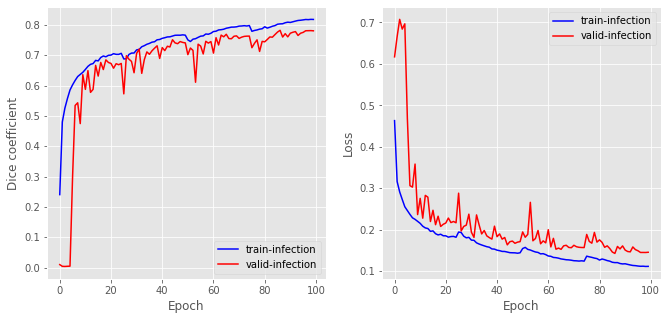

In [54]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(infection_segmentation_res.history['dice'], color='b', label='train-infection')
axes[0].plot(infection_segmentation_res.history['val_dice'], color='r', label='valid-infection')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(infection_segmentation_res.history['loss'], color='b', label='train-infection')
axes[1].plot(infection_segmentation_res.history['val_loss'], color='r', label='valid-infection')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend();

# 6. Saving loads

In [56]:
infection_segmentation.load_weights('infection_segmentation_weights.hdf5')
prediction = infection_segmentation.predict(X_test)

# 7. Testing

In [60]:
def plot_lung_seg(all_cts, all_lungs, all_inf, pred_infs, axes) :

    axes[0].imshow(all_cts[:,:,0], cmap='bone')
    axes[0].set_title('CT image'); plt.grid(None)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    
    axes[1].imshow(all_lungs[:,:,0], cmap='bone')
    axes[1].imshow(all_inf[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('Infection mask'); plt.grid(None)
    axes[1].set_xticks([]); axes[1].set_yticks([])

    axes[2].imshow(all_lungs[:,:,0], cmap='bone')
    axes[2].imshow(pred_infs[:,:,0], alpha=0.5, cmap='Reds')
    axes[2].set_title('Pred. Infection mask'); plt.grid(None)
    axes[2].set_xticks([]); axes[2].set_yticks([])

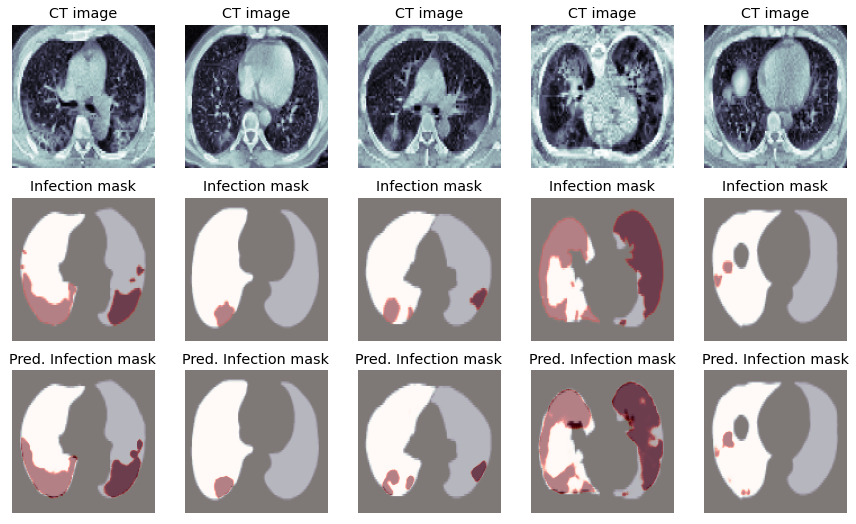

In [63]:
import random
indices = random.choices(range(len(X_test)), k=5)
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii, idx in enumerate(indices) :
    plot_lung_seg(X_test[idx], yl_test[idx], yi_test[idx], prediction[idx], list(axes[:,ii]))